<a href="https://colab.research.google.com/github/NatanDuarte/subtitles_dataset/blob/main/texto_em_cena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecimento de texto em cena - Natan Duarte / Guilherme Lopes

# RECONHECIMENTO DE TEXTO EM CENA APLICADO À EXTRAÇÃO LEGENDAS

Natan Duarte Procópio, Guilherme Lopes de Lima Souza

## RESUMO

Este trabalho tem como intenção aplicar o reconhecimento e processamento de imagens a fim de extrair legendas de vídeos com a utilização da ferramenta de extração de caracteres “Tesseract OCR”, demonstrando a capacidade didática dos alunos responsáveis pelo mesmo. Foram obtidas pelo menos 100 imagens - dentre elas, algumas estão em português, outras em inglês, e uma parte não tem legenda - a fim de demonstrar a eficiência do programa, bem como obter um amplo escopo de material para análise.

palavras-chave: extrair, legendas, processamento, OCR, análise.

# SCENE TEXT RECOGNITION APPLIED TO SUBTITLE EXTRACTION

## ABSTRACT

This essay intends to apply image recognition and processing in order to extract subtitles from videos, demonstrating the didactic ability of the students responsible for the project. At least 100 images were separated - among them, some are in Portuguese, others in English, and a part has no subtitles - in order to demonstrate the efficiency of the program, as well as to obtain a wide scope of material for analysis.

key-words: extract, subtitles, processing, OCR, analysis.

O texto na íntegra pode ser encontrado [neste repositório](https://github.com/NatanDuarte/subtitles_dataset)


## Configurações de ambiente necessárias

### Baixando dependências

⚠️ script sensível abaixo

esse script força um restart da máquina virtual para carregar a biblioteca baixada. **Ignore o pop-up de erro**.

In [ ]:
!pip install opencv-python pytesseract

from os import kill, getpid
kill(getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Configurando o Tesseract

#### Instalação do tesseract

In [ ]:
!sudo apt install -qq tesseract-ocr

tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
tesseract-ocr set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


#### Baixando a língua portuguesa

In [ ]:
!apt-get install -qq tesseract-ocr-por

!tesseract --list-langs

List of available languages (3):
eng
osd
por


## Importando dependências

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

%matplotlib inline

import os
import re
import json
import random
import cv2 as cv
import pytesseract
import numpy as np

from pytesseract import Output
from os import listdir, path

# Análise exploratória

## Úteis

In [ ]:
def get_image_paths(abs_path="/content/dataset"):
  all_paths = []
  all_images = listdir(abs_path)
  for image in all_images:
    all_paths.append(path.join(abs_path, image))
  return all_paths

def get_images(path_list=[]):
  #random.shuffle(path_list)
  images = []
  for path in path_list:
    images.append(cv.imread(path))
  return images

def get_region_of_interest(image):
  eighty_percent_of_frame = int(image.shape[0] * 0.8)
  return image[eighty_percent_of_frame::,:,:]

def segment_image(image):
  roi = get_region_of_interest(image)
  gray_roi = cv.cvtColor(roi, cv.COLOR_RGB2GRAY)
  _, thresh = cv.threshold(gray_roi, 235, 255, cv.THRESH_BINARY)
  enhanced = cv.medianBlur(thresh, 7)
  return cv.dilate(thresh, (3, 3))

def extract_text(image):
  if image is not None:
    return pytesseract.image_to_string(
      image, 
      lang='por+eng', 
      config='--tesseract-dir tessdata --psm 6', 
      output_type=Output.DICT
    )['text']

def segment(image):
  roi = get_region_of_interest(image)
  gray_roi = cv.cvtColor(roi, cv.COLOR_RGB2GRAY)
  _, thresh = cv.threshold(gray_roi, 220, 255, cv.THRESH_BINARY_INV)
  enhanced = cv.medianBlur(thresh, 7)
  return cv.dilate(thresh, (3, 3))

def write_json(path_list=[]):
  serializations = []
  for image_path in path_list:
    img = cv.imread(image_path)
    seg_img = segment(img)
    text = extract_text(seg_img)
    better_text = re.sub("(\s+|[\n+]|\-)", " ", text)
    better_text = better_text.strip()

    serialization = {}
    serialization['path'] = image_path
    serialization['content'] = better_text
    serializations.append(serialization)

  json_object = json.dumps(serializations, indent=4, ensure_ascii=False)
  with open("/content/baseline.json", "w") as outfile:
      outfile.write(json_object)

## Obtenção das imagens

⚠️ Favor rodar apenas uma vez.

O Script abaixo baixa as imagens do github e copia ela para um diretório padrão, depois deleta o repositório baixado. 

baixa também o json que usamos de baseline.



In [ ]:
!git init --quiet
!git clone https://github.com/NatanDuarte/subtitles_dataset.git

!mkdir dataset
!cp subtitles_dataset/dataset/* ./dataset
!cp subtitles_dataset/* .

!rm -rf subtitles_dataset/

Cloning into 'subtitles_dataset'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 110 (delta 1), reused 106 (delta 0), pack-reused 0
Receiving objects: 100% (110/110), 15.34 MiB | 31.18 MiB/s, done.
Resolving deltas: 100% (1/1), done.
mkdir: cannot create directory ‘dataset’: File exists
cp: -r not specified; omitting directory 'subtitles_dataset/dataset'


In [ ]:
images = get_images(get_image_paths())

print(f'imagens carregadas: {len(images)}')

imagens carregadas: 100


## Scripts de pré-processamento

Note que o dataset importado acima já passou por estes tratamentos. Boa parte dessas funções estão aqui como registro.

In [ ]:
def pre_processing(image_list=[]):
  processed_images = []
  for image in image_list:
    image = cv.resize(image, (640, 280), cv.INTER_AREA)
    eighty_percent_of_frame = int(image.shape[0] * 0.8)
    blured = cv.medianBlur(image[:eighty_percent_of_frame,:,:], 11)
    twenty_percent_of_frame = image[eighty_percent_of_frame::,:,:]
    full_frame = np.concatenate([blured, twenty_percent_of_frame])
    processed_images.append(full_frame)
  return processed_images

def write_images(dir_path='dataset', title='image-', image_list=[]):
  random.shuffle(image_list)
  if not path.exists(dir_path):
    os.makedirs(dir_path)
  for count, image in enumerate(image_list):
    new_name = path.join(dir_path, f'{title}{count+1}.png')
    cv.imwrite(new_name, image)

def apply_pre_processing(abs_path):
  try:
      paths = get_image_paths(abs_path="scenes")
      images = get_images(paths)
      outputs = pre_processing(images)
      write_images(image_list=outputs)
  except:
      print("flow error")

## Segmentação

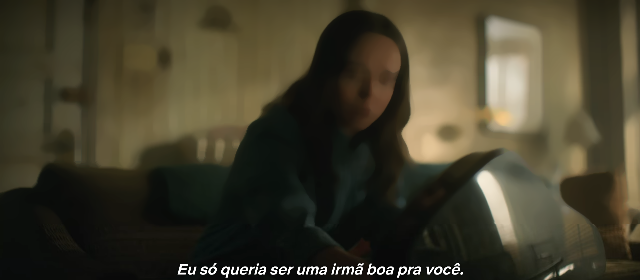

In [ ]:
cv2_imshow(images[9])

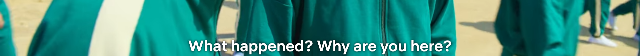

In [ ]:
# alterar o numero no array para testar com outra imagem
roi = get_region_of_interest(images[82])

cv2_imshow(roi)

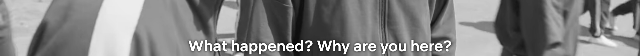

In [ ]:
gray_roi = cv.cvtColor(roi, cv.COLOR_RGB2GRAY)

cv2_imshow(gray_roi)

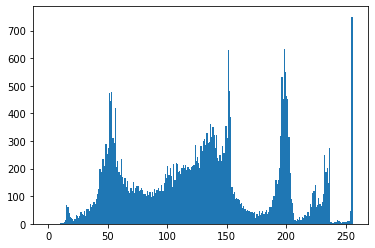

In [ ]:
plt.hist(gray_roi.ravel(),256,[0,256])
plt.show()

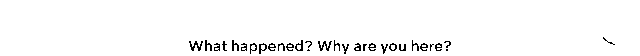

In [ ]:
_, thresh = cv.threshold(gray_roi, 242, 255, cv.THRESH_BINARY_INV)
cv2_imshow(thresh)

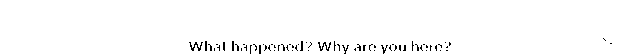

In [ ]:
enhanced = cv.medianBlur(thresh, 5)
enhanced = cv.dilate(thresh, (3, 3))

cv2_imshow(enhanced)

In [ ]:
import re
extracted_content = extract_text(enhanced)
extracted_content = extract_text(thresh)

res_str = re.sub("(\s+|[\n+])"," ", extracted_content)
res_str = res_str.strip()
print(res_str)

# Inferências e comparação de resultados



In [ ]:
import json
from difflib import SequenceMatcher

In [ ]:
def pipeline1(path="/content/baseline.json"):
  with open(path, 'r') as json_file:
    baseline = json.loads(json_file.read())

  accuracy = 0
  for item in baseline:
    img = cv.imread(item['path'])
    extracted_content = extract_text(img)
    res_str = re.sub("(\s+|[\n+])"," ", extracted_content)
    res_str = res_str.strip()

    accuracy += SequenceMatcher(
        None, 
        item['content'], 
        res_str
    ).ratio()
  return accuracy


pipeline1()

46.737758755420046

In [ ]:
def pipeline2(path="/content/baseline.json"):
  with open(path, 'r') as json_file:
    baseline = json.loads(json_file.read())

  accuracy = 0
  for item in baseline:
    img = cv.imread(item['path'])
    roi = get_region_of_interest(img)
    gray_roi = cv.cvtColor(roi, cv.COLOR_RGB2GRAY)
    _, thresh = cv.threshold(gray_roi, 232, 255, cv.THRESH_BINARY_INV)
    enhanced = cv.medianBlur(thresh, 5)
    enhanced = cv.dilate(thresh, (3, 3))
    extracted_content = extract_text(enhanced)
    res_str = re.sub("(\s+|[\n+])"," ", extracted_content)
    res_str = res_str.strip()

    accuracy += SequenceMatcher(
        None, 
        item['content'], 
        res_str
    ).ratio()
  return accuracy


pipeline2()

92.78502448573623

In [ ]:
def pipeline3(path="/content/baseline.json"):
  with open(path, 'r') as json_file:
    baseline = json.loads(json_file.read())

  accuracy = 0
  for item in baseline:
    img = cv.imread(item['path'])
    roi = get_region_of_interest(img)
    gray_roi = cv.cvtColor(roi, cv.COLOR_RGB2GRAY)
    _, thresh = cv.threshold(gray_roi, 232, 255, cv.THRESH_BINARY_INV)
    extracted_content = extract_text(thresh)
    res_str = re.sub("(\s+|[\n+])"," ", extracted_content)
    res_str = res_str.strip()

    accuracy += SequenceMatcher(
        None, 
        item['content'], 
        res_str
    ).ratio()
  return accuracy


pipeline3()

97.0984087842014